In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, root_mean_squared_error
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

Let's login into wandb

In [2]:
wandb.login(key = '')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: timyun. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Timur\.netrc


True

Loading descriptors

In [3]:
descriptors = pd.read_csv('table_with_desriptors.csv', index_col = 0)

Fltering only non-NaNs values of **Pc**, creating *X* and *Y* dataframes and dropping unnecessary columns

In [4]:
descriptors = descriptors[~descriptors['Pc'].isnull()]
y = descriptors['Pc']
descriptors = descriptors.drop(columns = ['SMILES', 'Tc', 'Pc', 'omega', 'mol'])

Let's plot the distribution of **Pc** with violinplot. 

(0.0, 100.0)

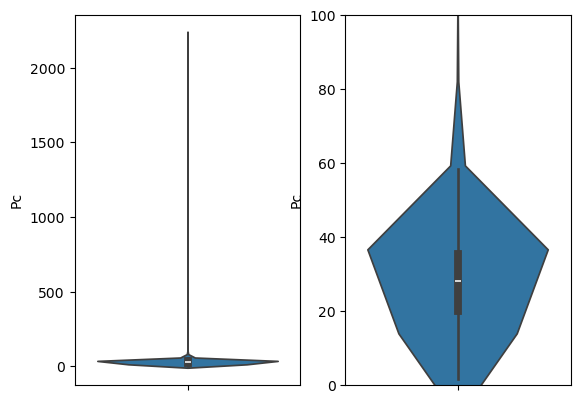

In [5]:
fog, axes = plt.subplots(1,2)
sns.violinplot(data = y, ax = axes[0])
sns.violinplot(data = y, ax = axes[1])
axes[1].set_ylim(0,100)

Let's get the info. We can see, that most of values are in the range of 0 - 60 bar, 75% percentile is 35 bar. However, there is a huge outlier of 2230 bar, that can distort calculations. Therefore, let's filter all values and limit out prediction at 95% percentile, which is **48.7 bar**

In [6]:
print(y.describe())
quant_95 = y.quantile(q = 0.95)
print('95% quantile is {}'.format(quant_95))

count    6470.000000
mean       28.901843
std        30.441236
min         1.510000
25%        19.810000
50%        28.100000
75%        35.200000
max      2230.000000
Name: Pc, dtype: float64
95% quantile is 48.7


Filtering datasets according to our limitation and creating train, test and valid subsets

In [8]:
mask = y < quant_95
y = y[mask]
descriptors = descriptors[mask]
X_train, X_test, y_train, y_test = train_test_split(descriptors, y, test_size = 0.15, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state = 0)


Let's select columns to scale (only numeric descriptors values, not fingerprints), create the instance of Scikit learn column transformer and fit and transform all subsets

In [9]:
columns_to_scale = list(X_train.columns[:156])

In [10]:
ct = ColumnTransformer([('Scaler', MinMaxScaler(),columns_to_scale)], remainder= 'passthrough')

In [11]:
X_train = ct.fit_transform(X_train)
#ct is fiited only on X_train!
X_test = ct.transform(X_test)
X_valid = ct.transform(X_valid)

Let's create Pytorch datasets

In [12]:
X_train_ds = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train.values, dtype = torch.float32))
X_test_ds = TensorDataset(torch.tensor(X_test, dtype = torch.float32), torch.tensor(y_test.values, dtype = torch.float32))
X_valid_ds = TensorDataset(torch.tensor(X_valid, dtype = torch.float32), torch.tensor(y_valid.values, dtype = torch.float32))


And Pytorch DataLoaders with batch size of 24

In [13]:
torch.manual_seed(1)
batch_size = 24
X_train_dl = DataLoader(X_train_ds, shuffle = True, batch_size = batch_size)
X_valid_dl = DataLoader(X_valid_ds, shuffle = True, batch_size = batch_size)

Then we just create Model class with fully connected Neural Network, that receive Descriptors, goes through it. The final result of 
```
nn.Linear(round(self.input_size),1)
```

Is the value of **Pc**  
Is should be noted, that this class is modified during model selection and all runs are monitored at wandb website

In [24]:
class MyModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.linear_1 = nn.Linear(self.input_size, round(self.input_size))
        self.a1 = nn.GELU(approximate = 'none')
        self.dropout_1 = nn.Dropout(p = 0.3)
        self.linear_2 = nn.Linear(round(self.input_size), round(self.input_size))
        self.a2 = nn.GELU(approximate = 'none')
        self.dropout_2 = nn.Dropout(p = 0.3)
        self.linear_3 = nn.Linear(round(self.input_size),1)
        
    
    def forward(self, x):
        x = self.linear_1(x)
        x = self.a1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.a2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        return x
model = MyModel(X_train.shape[1])

Here we change learning rate, n_epochs, optimizer parameters, select loss function and initialize wandb ran, which describes model parameters and architecture

In [25]:
lr = 0.0005
model = MyModel(X_train.shape[1])
model = model.to('cuda:0')
loss_fn = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-4)
n_epochs = 200

wandb.init(project = 'critical_pressure_prediction', 
           config = {'learning_rate':lr,
                     'acrhitecture':'2204 -> 2204  -> GLU -> dropout - 2204 -> GLU  -> dropout -> 1',
                     'dataset':'custom_dataset',
                     'epochs':n_epochs})

And run training and validation

In [26]:
                   
train_hist_loss = []
valid_hist_loss = []
#two list instances store loss values on training and validation
for i in range(n_epochs):
    model.train()
    train_loss = 0
    for X_b, y_b in X_train_dl:
        X_b = X_b.to('cuda:0')
        y_b = y_b.to('cuda:0')
        pred = model(X_b)
        loss = loss_fn(pred.squeeze(), y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        #increasing overall train_loss at every step
    #and adding the average valie of train loss for the epoch into history
    train_hist_loss.append(train_loss/len(X_train_dl))
    #this step logs train_loss for wandb
    wandb.log({'train_loss':train_hist_loss[-1], 'train_rmse':np.sqrt(train_hist_loss[-1])})
    model.eval()
    valid_loss = 0
    for X_b, y_b in X_valid_dl:
        X_b = X_b.to('cuda:0')
        y_b = y_b.to('cuda:0')
        pred = model(X_b)
        loss = loss_fn(pred.squeeze(), y_b)
        valid_loss += loss.item()
    valid_hist_loss.append(valid_loss/len(X_train_dl))
    #res_valid is used to calculate R2, which is logged by wandb
    res_valid = model(torch.tensor(X_valid, dtype = torch.float32).to('cuda:0'))
    #For validation steps, wandb logs not only pure loss, but also RMSE and R2
    wandb.log({'valid_loss':valid_hist_loss[-1], 
              'valid_rmse':np.sqrt(valid_hist_loss[-1]), 
               'valid_r2':(r2_score(res_valid.cpu().detach().numpy().squeeze(), y_valid))})
    if (i%10 ==0):
        print('Эпоха {}, ошибка тестирования - {}, ошибка валидации - {}'.format(i, train_hist_loss[-1], valid_hist_loss[-1]))           
wandb.finish()

Эпоха 0, ошибка тестирования - 86.25066829114347, ошибка валидации - 2.7472088736456794
Эпоха 10, ошибка тестирования - 3.4144970623222557, ошибка валидации - 1.246024990081787
Эпоха 20, ошибка тестирования - 2.36250281849423, ошибка валидации - 1.1839040266500938
Эпоха 30, ошибка тестирования - 1.7478976813522544, ошибка валидации - 1.1094997857068036
Эпоха 40, ошибка тестирования - 1.2499373809711354, ошибка валидации - 1.0653437466234774
Эпоха 50, ошибка тестирования - 1.1417627746994432, ошибка валидации - 0.9576317561639321
Эпоха 60, ошибка тестирования - 1.0733253018276112, ошибка валидации - 0.9872273921966552
Эпоха 70, ошибка тестирования - 1.2298347804997418, ошибка валидации - 0.9355247510446084
Эпоха 80, ошибка тестирования - 1.1708230306973328, ошибка валидации - 0.9480010760797036
Эпоха 90, ошибка тестирования - 1.021008861870379, ошибка валидации - 0.9477893391171017
Эпоха 100, ошибка тестирования - 1.116007206891034, ошибка валидации - 0.9039665557242729
Эпоха 110, ошибк

train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_rmse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
valid_loss,█▅▄▄▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▂▂▁▂▁▂▁▂▁
valid_r2,▁▃▁▅▅▆▇▆▇▇▇▇▇▇▇█▇▇▇▇█▇▇█▇▇▇▇█▇▇█▇███▇▇▇▇
valid_rmse,█▆▇▅▅▅▄▅▃▃▃▂▂▃▃▃▂▂▃▂▂▂▃▂▂▂▂▁▂▂▂▂▁▃▂▂▁▁▂▂
train_loss,1.18169
train_rmse,1.08706
valid_loss,0.86167
valid_r2,0.95276
valid_rmse,0.92826


In [16]:
import matplotlib.pyplot as plt

Sometimes is is useful just to draw predicted values vs real values

(0.0, 100.0)

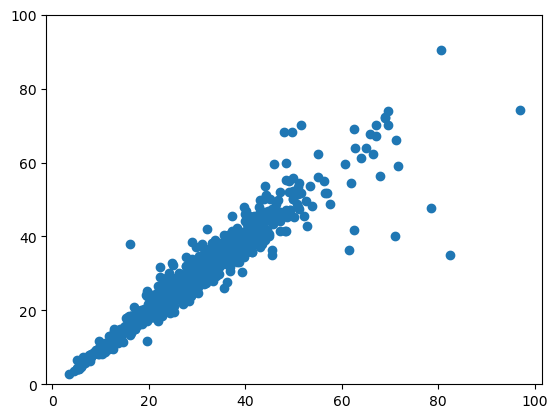

In [17]:
plt.scatter(model(X_test_ds.tensors[0].to('cuda:0')).detach().cpu().numpy(), y_test)
plt.ylim(0,100)